In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta del directorio en Google Drive
data_dir = '/content/drive/MyDrive/tensorflow'

# Cargar el conjunto de datos desde Google Drive
datos, metadatos = tfds.load(
    'comidas_dataset',
    split='train[:50%]',
    as_supervised=True,
    with_info=True,
    data_dir=data_dir
)

# Obtener el conjunto de datos completo
#datos_completos = datos['train']
datos_completos = datos

# Imprimir la estructura de las características
print(metadatos.features)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=30),
})


In [ ]:
# Definir la etiqueta de clase
nombre_etiqueta = 'label'

# Obtener el número de clases
num_clases = metadatos.features[nombre_etiqueta].num_classes
nombres_objetos = [str(i) for i in range(num_clases)]

# Función para normalizar las imágenes
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255.0
    return imagenes, etiquetas

# Función para preprocesar las imágenes (redimensionar)
def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])
    return image, label

# Aplicar las funciones de normalización y preprocesamiento
datos_completos = datos_completos.map(normalizar)
datos_completos = datos_completos.map(preprocess)

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
num_ejemplos = metadatos.splits['train'].num_examples
num_entrenamiento = int(0.8 * num_ejemplos)
num_pruebas = num_ejemplos - num_entrenamiento

datos_entrenamiento = datos_completos.take(num_entrenamiento)
datos_pruebas = datos_completos.skip(num_entrenamiento)

# Cachear los datos
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

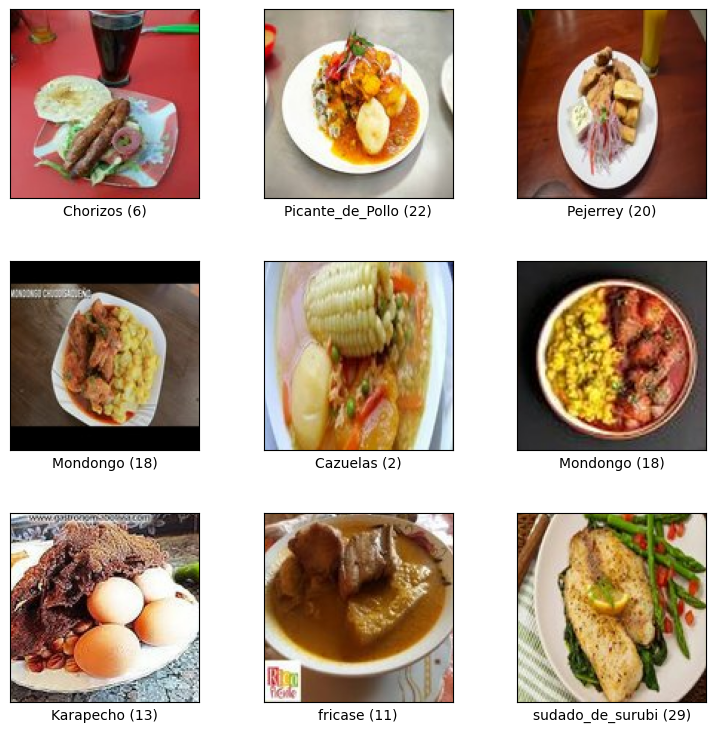

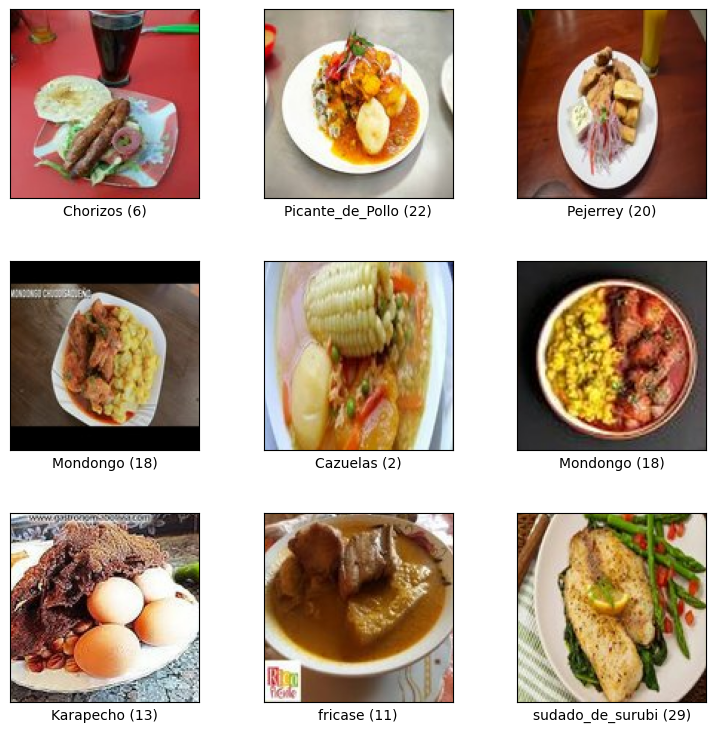

In [ ]:
# Visualizar algunas imágenes de entrenamiento
tfds.visualization.show_examples(datos_entrenamiento, metadatos)

In [ ]:
# Crear el modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

# Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
TAMANO_LOTE = 32

# Configurar los datos para el entrenamiento y la evaluación
datos_entrenamiento = datos_entrenamiento.shuffle(num_entrenamiento).batch(TAMANO_LOTE).repeat()
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
# Entrenar el modelo
import math
historial = modelo.fit(
    datos_entrenamiento,
    epochs=10,
    steps_per_epoch=math.ceil(num_entrenamiento / TAMANO_LOTE),
    validation_data=datos_pruebas,
    validation_steps=math.ceil(num_pruebas / TAMANO_LOTE)
)

Epoch 1/10
747/748 [============================>.] - ETA: 0s - loss: 2.2613 - accuracy: 0.3666

748/748 [==============================] - 32s 21ms/step - loss: 2.2600 - accuracy: 0.3671
Epoch 2/10
748/748 [==============================] - 14s 18ms/step - loss: 0.9141 - accuracy: 0.7439
Epoch 3/10
748/748 [==============================] - 14s 19ms/step - loss: 0.3727 - accuracy: 0.8950
Epoch 4/10
748/748 [==============================] - 14s 19ms/step - loss: 0.2349 - accuracy: 0.9369
Epoch 5/10
748/748 [==============================] - 15s 20ms/step - loss: 0.1813 - accuracy: 0.9471
Epoch 6/10
748/748 [==============================] - 14s 19ms/step - loss: 0.1700 - accuracy: 0.9471
Epoch 7/10
748/748 [==============================] - 14s 19ms/step - loss: 0.1599 - accuracy: 0.9469
Epoch 8/10
748/748 [==============================] - 14s 19ms/step - loss: 0.1494 - accuracy: 0.9504
Epoch 9/10
748/748 [==============================] - 14s 19ms/step - loss: 0.1377 - accuracy: 0.9510
Epoch 10/10
748/748 [==============================] - 14s 18ms/step - loss: 0.1278 - accurac

1/1 [==============================] - 0s 18ms/step


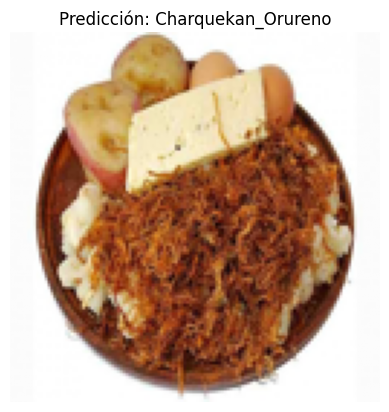

In [ ]:
# Definir los nombres de las clases
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO
nombres_objetos = [
    'Aji_de_pataskha', 'caldo_de_bagre', 'Cazuelas', 'Chairo', 'Charquekan_Orureno',
    'chicharron', 'Chorizos', 'cunape', 'empanada_de_arroz', 'Falso_Conejo', 'faropa',
    'fricase', 'fritanga', 'Karapecho', 'keperi_beniano', 'La_kalapurka', 'locro',
    'majao', 'Mondongo', 'pacu', 'Pejerrey', 'Picana', 'Picante_de_Pollo', 'pique',
    'Ranga', 'Saice', 'silpancho', 'Sopa_de_Mani', 'Sopa_De_Quinua', 'sudado_de_surubi'
]

# URL de ejemplo de una imagen
url = 'https://www.cocina-boliviana.com/base/stock/Recipe/424-image/424-image_web.jpg'

# Función para cargar y preprocesar la imagen
def cargar_y_preprocesar_imagen(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = image.resize((128, 128))  # Redimensionar a 128x128 píxeles
    image = np.array(image)
    image = image / 255.0  # Normalizar la imagen
    image = np.expand_dims(image, axis=0)  # Agregar una dimensión para el lote
    return image

# Función para hacer una predicción
def predecir_imagen(url):
    imagen_preprocesada = cargar_y_preprocesar_imagen(url)
    predicciones = modelo.predict(imagen_preprocesada)
    return predicciones

# Función para mostrar la imagen y la predicción
def mostrar_resultado(url):
    imagen_preprocesada = cargar_y_preprocesar_imagen(url)
    predicciones = predecir_imagen(url)

    # Obtener la clase con mayor probabilidad
    clase_predicha = np.argmax(predicciones, axis=1)[0]

    # Mapear la clase a su nombre (nombres_objetos es la lista de nombres de clases)
    nombre_clase = nombres_objetos[clase_predicha]

    # Mostrar la imagen
    plt.imshow(imagen_preprocesada[0])
    plt.title(f'Predicción: {nombre_clase}')
    plt.axis('off')
    plt.show()

# Probar con una URL
mostrar_resultado(url)

dict_keys(['loss', 'accuracy'])


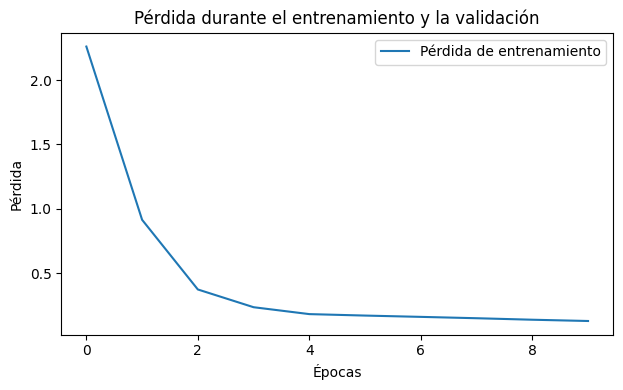

In [ ]:

# Verificar las claves disponibles en el historial
print(historial.history.keys())

# Crear la figura y subgráficas
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(historial.history['loss'], label='Pérdida de entrenamiento')
if 'val_loss' in historial.history:
    plt.plot(historial.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()


# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
#exportar el modelo en h5
modelo.save('comidas.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls

comidas.h5  drive  sample_data


In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras comidas.h5 carpeta_salida

2024-05-29 16:52:35.817276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 16:52:36.846699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!ls carpeta_salida

group1-shard1of4.bin  group1-shard2of4.bin  group1-shard3of4.bin  group1-shard4of4.bin	model.json
